# The Music of the Sphere: Reconstruction test from mock data using SVD decomposition

*Laurence Perreault Levasseur, Phil Marshall, and Roger Blandford, January 2016*

In this notebook we generate a mock Universe and use the likelihood from Music allegro paper to reconstruct the 3D map of the interior sphere.

To do this we make use of 100 posterior sample Commander Planck CMB temperature maps to calculate the $a_lm$'s covariance matrix, and use a prior for the $f_n$'s constructed from a primordial power spectrum with amplitude given by Planck and a spectral index of 0.97. To do the reconstruction we do not use a mask on the T map and use SVD to deal with all ill-conditioned matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import beatbox
import os.path
%matplotlib inline

1


In [3]:
You=beatbox.Multiverse(truncated_nmax=3, truncated_nmin=1, truncated_lmax=8, truncated_lmin=1)
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  122  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 8.9e-06


beatbox/universe.py:525: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


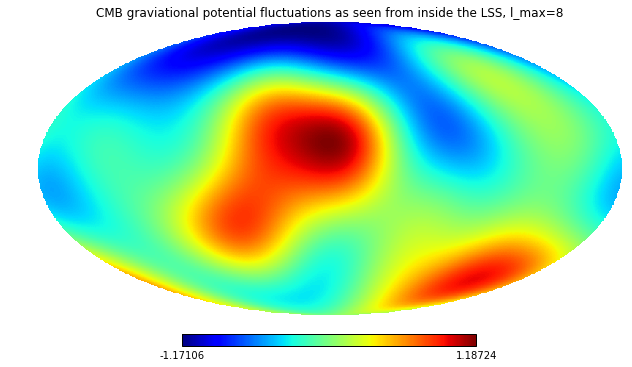

In [4]:
# Plot the generated T map
%matplotlib inline
import healpy as hp
beatbox.You.all_simulated_universes[-1].show_CMB_T_map(from_perspective_of="observer")

In [5]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated
if not os.path.isfile('data/covCyy_lmax8.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='covCyy_lmax10_nmax20.txt')
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax8.txt')

In [6]:
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


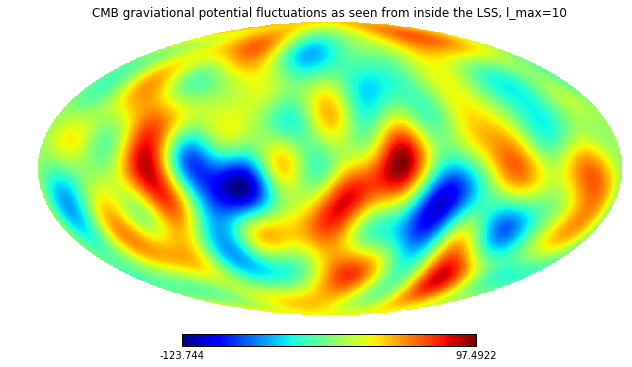

In [7]:
beatbox.You.all_data_universes = np.append(beatbox.You.all_data_universes, beatbox.Universe())
beatbox.You.all_data_universes[-1].read_in_CMB_T_map(from_this='data/commander_32band_Clsamples100/cmb_Cl_c0001_k00030.fits')
beatbox.You.all_data_universes[-1].decompose_T_map_into_spherical_harmonics()
beatbox.You.all_data_universes[-1].alm2ay()
beatbox.You.all_data_universes[-1].ay2alm(beatbox.You.all_data_universes[-1].ay)
beatbox.You.all_data_universes[-1].show_CMB_T_map(from_perspective_of="observer")

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


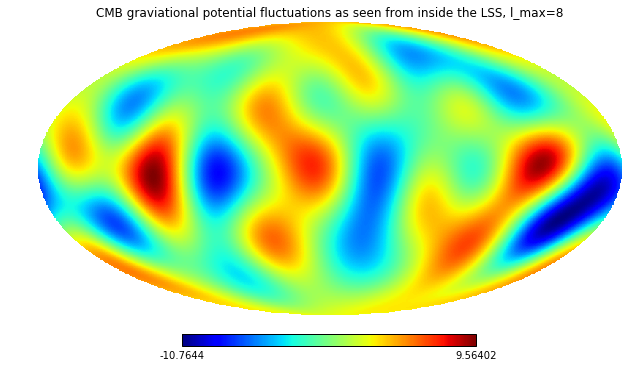

In [7]:
beatbox.You.all_data_universes = np.append(beatbox.You.all_data_universes, beatbox.Universe())
beatbox.You.all_data_universes[-1].ay = np.loadtxt("data/Rogersay.txt").view(complex)
beatbox.You.all_data_universes[-1].ay2alm(beatbox.You.all_data_universes[-1].ay,truncated_lmax=8, truncated_lmin=1, usedefault=0)
beatbox.You.all_data_universes[-1].show_CMB_T_map(from_perspective_of="observer")


In [7]:
# Use the simulated Universe as mock data
# First, generate one realization of noise
noise = beatbox.You.generate_one_realization_of_noise()
# Add the noise to the realization of the sky map
datamap=beatbox.You.all_simulated_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)+noise
datamap=datamap.T

beatbox/universe.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  ay_real[zero_ind] = value[zero_ind].astype(np.float)


In [13]:
# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)

beatbox/multiverse.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
  R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


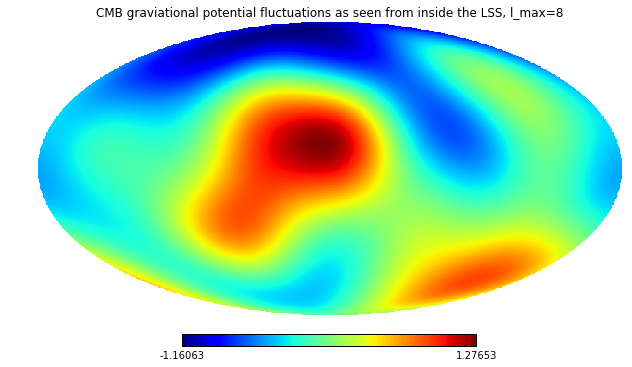

In [18]:
# Give those reconstructed f_n's to one realization of the Universe
We=beatbox.Universe()
We.fn=beatbox.You.reconstrunct_fn
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")

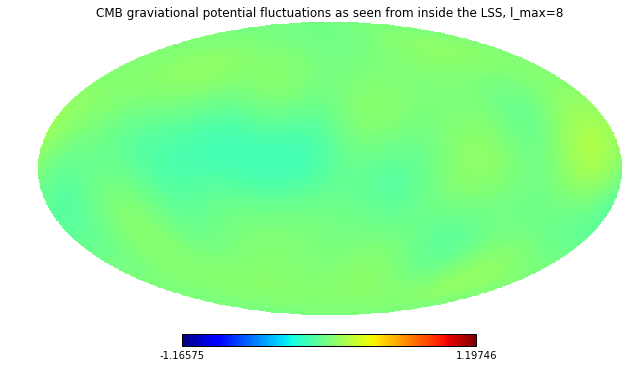

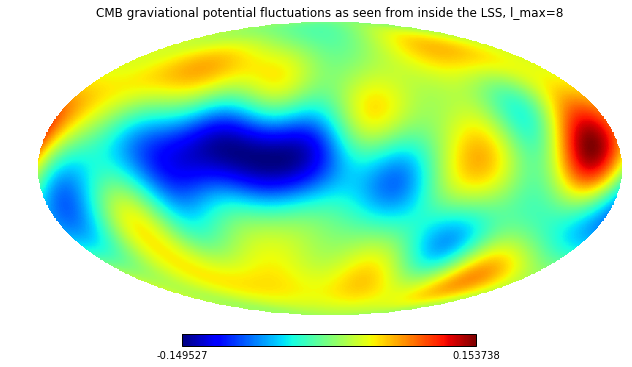

In [17]:
# Plot the residuals:
WeRes=beatbox.Universe()
WeRes.ay=(beatbox.You.all_simulated_universes[-1].ay-We.ay)

WeRes.ay2alm(WeRes.ay)

hp.mollview(beatbox.You.all_simulated_universes[-1].Tmap-We.Tmap, min=-1.16575, max=1.19746, rot=(-90,0,0),title="CMB graviational potential fluctuations as seen from inside the LSS, l_max=%d" % We.truncated_lmax)

WeRes.show_CMB_T_map( from_perspective_of="observer")

1
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


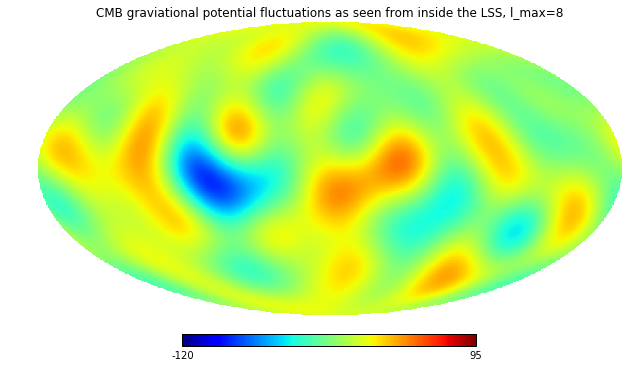

In [13]:
# Plot the residuals:
WeRes=beatbox.Universe()
WeRes.ay=(beatbox.You.all_data_universes[-1].ay-We.ay)

WeRes.ay2alm(WeRes.ay)
WeRes.show_CMB_T_map( from_perspective_of="observer")

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


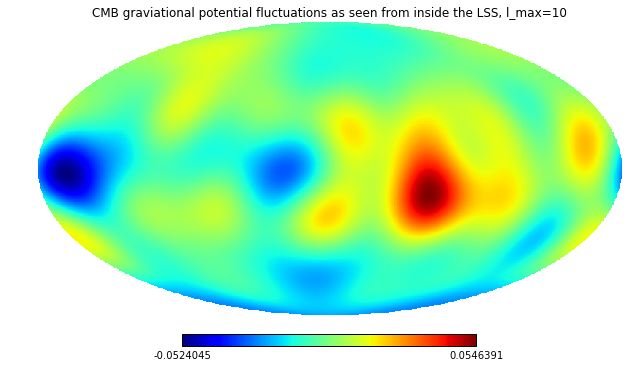

In [24]:
# Plot the residuals:
WeRes=beatbox.Universe()
WeRes.ay=beatbox.You.all_simulated_universes[-1].ay-We.ay
WeRes.ay2alm(WeRes.ay)
WeRes.show_CMB_T_map( from_perspective_of="observer")

In [ ]:
# From those f_n's build the 3d spatial potential:
ind = np.where(We.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = We.kx[ind], We.ky[ind], We.kz[ind]


RealPhi = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase = k_x[i] * We.x + k_y[i] * We.y + k_z[i] * We.z
    RealPhi += (We.fn[i] * np.cos(phase)+We.fn[len(k_x)-1-i]*np.sin(phase))*We.Deltak**3
    We.phi = RealPhi.real

In [ ]:
import yt 
We.Pdist=1
We.Pmax=2*np.pi
We.show_potential_with_yt(angle=np.pi/2,  N_layer=5, cmap='BrBG', show3D=1)

In [ ]:
We.show_potential_from_all_angles_with_yt('UNIVERSE.gif')

In [ ]:
ind = np.where(beatbox.Universe.kfilter>0)
PS = np.zeros(2*len(ind[1]))
PS[:len(ind[1])] = (beatbox.You.all_simulated_universes[-1].Power_Spectrum[ind]/2)
PS[len(ind[1]):] = (beatbox.You.all_simulated_universes[-1].Power_Spectrum[ind]/2)

F=sum(((We.fn.reshape(len(PS),1) - beatbox.You.all_simulated_universes[-1].fn.reshape(len(PS),1))/PS.reshape(len(PS),1))**2)

In [ ]:
F/len(PS)

In [ ]:
f= open("data/f_ns.txt", 'r')
data = f.read()
f.close()
columns = data.split()
f_n=np.zeros(len(columns))
for count in range(int(len(columns))):
    f_n[count] = float(columns[count])
        
g= open("data/fncoordinates.txt", 'r')
data2 = g.read()
g.close()
columns2 = data2.split()
k_vec=np.zeros(len(columns2))
for count2 in range(int(len(columns2))):
    k_vec[count2] = float(columns2[count2])
        
k_x=k_vec[0::3]
k_y=k_vec[1::3]
k_z=k_vec[2::3]

print f_n[:10]
print k_vec[:10]
print We.fn[:10]
ind = np.where(beatbox.Universe.kfilter>0)
print We.kx[ind], We.ky[ind], We.kz[ind]

In [ ]:
print beatbox.You.all_data_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)[:10]
print We.ay2ayreal_for_inference(We.ay)[:10]
print We.ay2ayreal_for_inference(np.dot(We.R,We.fn))[:10]
print beatbox.You.all_data_universes[-1].alm[:10]
print 0.5*We.alm[:10]
print np.mean(beatbox.You.all_data_universes[-1].alm[1:]/We.alm[1:])
print WeRes.alm[:10]

In [ ]:
We.show_potential_from_all_angles_with_yt(output='recon.gif')

In [ ]:
print beatbox.You.A
print beatbox.You.inv_A
print np.dot(beatbox.You.A,beatbox.You.inv_A)

In [16]:
# Select the m values out the the lms tupples
m = np.array([m[1] for m in beatbox.Universe.lms])
# Find the indices of the positive ms
pos_ind = (m>0)
# Find the indices of the m=0
zero_ind = (m==0)
# Find the indices of the negative ms
neg_ind = (m<0)
R_real = np.zeros((len(beatbox.Universe.lms), len(beatbox.You.all_simulated_universes[0].fn)), dtype=np.float)
        
R_real[pos_ind,:] = beatbox.Universe.R[pos_ind,:].real
R_real[neg_ind,:] = beatbox.Universe.R[pos_ind,:].imag
R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


/Users/LaurencePeanuts/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
R_real.shape[1]

1848